In [4]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

In [5]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [9]:
for example, label in train_dataset:
  print('text: ', example.numpy())
  print('label: ', label.numpy())
  break

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I think that most of the folks who have posted comments on this movie don't understand how to watch a movie and/or have little sense of elegance. First, to assess a movie you need to understand the extent to which everything in the film works together. Modern sensibilities demand great drama. No, I don't mean great setting of characters and plots, but they seem to demand emotional trajectories that are greatly tragic or greatly comedic. This is a subtle movie. Its beauty lies in its subtlety (not to be confused with simplicity). Neither the story nor the characters are simple in this movie. It is a beautifully filmed movie that makes the most of combining sensuousness, politics, human weakness, venality...you name it. The world it's set in would be alien and not understood today...a world where if you have it you have to flaunt it NOW and LOUDLY, even if you only think you have it.<br /><br />Many people today don't understand that Victorian society wasn't really Victorian a

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 103,  12, ...,   0,   0,   0],
       [ 11,   7,  34, ...,   0,   0,   0],
       [ 10, 581, 126, ...,   0,   0,   0]], dtype=int64)

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I think that most of the folks who have posted comments on this movie don't understand how to watch a movie and/or have little sense of elegance. First, to assess a movie you need to understand the extent to which everything in the film works together. Modern sensibilities demand great drama. No, I don't mean great setting of characters and plots, but they seem to demand emotional trajectories that are greatly tragic or greatly comedic. This is a subtle movie. Its beauty lies in its subtlety (not to be confused with simplicity). Neither the story nor the characters are simple in this movie. It is a beautifully filmed movie that makes the most of combining sensuousness, politics, human weakness, venality...you name it. The world it's set in would be alien and not understood today...a world where if you have it you have to flaunt it NOW and LOUDLY, even if you only think you have it.<br /><br />Many people today don't understand that Victorian society wasn't really Victorian

In [20]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Compile the Keras model to configure the training process:

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [22]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 176s 436ms/step - accuracy: 0.5013 - loss: 0.6934 - val_accuracy: 0.4917 - val_loss: 0.6941
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 173s 441ms/step - accuracy: 0.4997 - loss: 0.6910 - val_accuracy: 0.5026 - val_loss: 0.6894
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 166s 424ms/step - accuracy: 0.4975 - loss: 0.6841 - val_accuracy: 0.5188 - val_loss: 0.6875
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 163s 416ms/step - accuracy: 0.5106 - loss: 0.6840 - val_accuracy: 0.5203 - val_loss: 0.6791
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 163s 416ms/step - accuracy: 0.5046 - loss: 0.6738 - val_accuracy: 0.5891 - val_loss: 0.6199
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 161s 410ms/step - accuracy: 0.6017 - loss: 0.6445 - val_accuracy: 0.4948 - val_loss: 0.6643
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 160s 410ms/step - accuracy: 0.5025 - loss: 0.6801 - val_accuracy: 0.5094 - val_loss: 0.6710
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 161s 413ms/step - accuracy: 0.5168 -

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 115ms/step - accuracy: 0.6684 - loss: 0.5770
Test Loss: 0.5752939581871033
Test Accuracy: 0.6714400053024292


(0.0, 0.700505617260933)

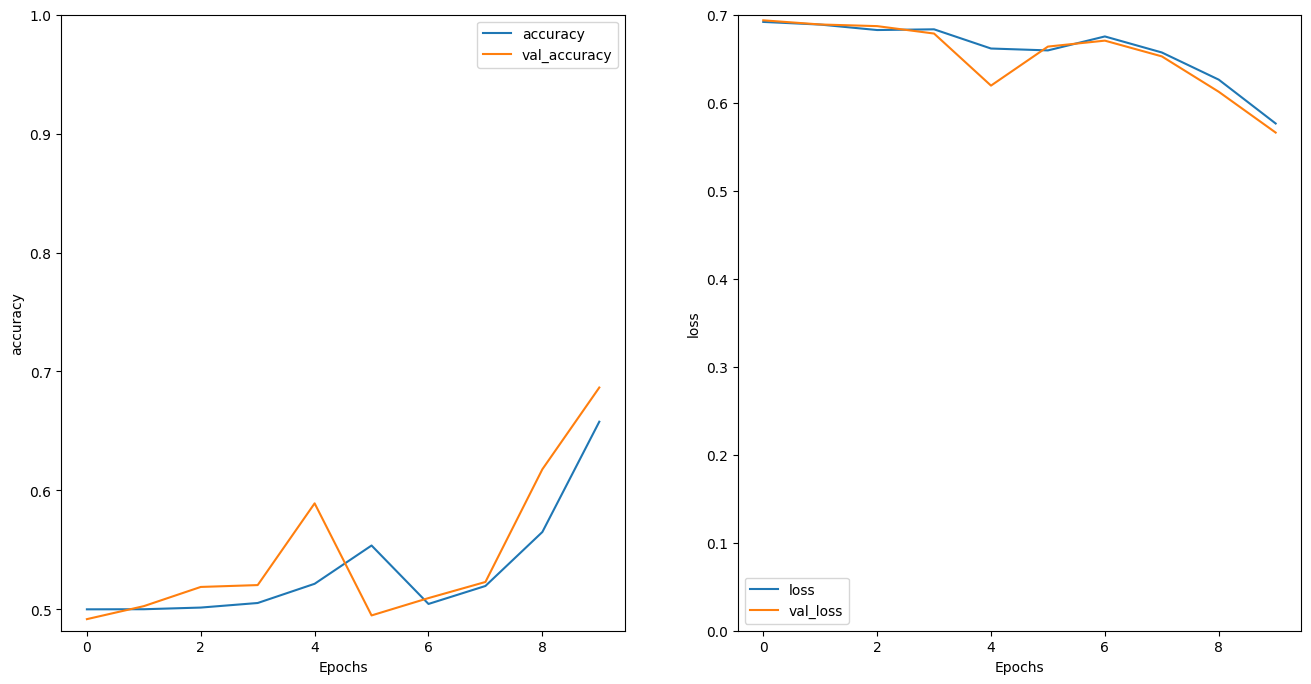

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))